## **Import Necessary Libraries**

In [1]:
import numpy as np
from libsvm.svmutil import svm_save_model, svm_load_model, svm_predict
from liblinear.liblinearutil import save_model, load_model, predict
import time
import os
import matplotlib.pyplot as plt

## **Import Functions from train.py**

In [2]:
from train import get_data, spatial_frequency_feature_fusion, prepare_data, train_linear_model, visualize

## **Run this for preprocessing**

- must include /utils
- example path: "/Users/Danniel/Detection-of-GAN-Generated-Images-using-Spatial-Frequency-Domain-Fusion-Data/utils"

In [3]:
import sys
# path of the folder "Detection-of-GAN-Generated-Images-using-Spatial-Frequency-Domain-Fusion-Data"
sys.path.append("/Users/Danniel/Detection-of-GAN-Generated-Images-using-Spatial-Frequency-Domain-Fusion-Data/utils")

from preprocessing_save import load_image, save_image

# directory for reading
img_gan = "/Users/Danniel/Downloads/Datasets/Datasets Animals/Train/GAN train"
img_real = "/Users/Danniel/Downloads/Datasets/Datasets Animals/Train/Real train"

# directory for saving (must be an empty folder)
save_dir_gan = "/Users/Danniel/Downloads/Datasets/Datasets Animals/Train/P_GAN_Train"
save_dir_real = "/Users/Danniel/Downloads/Datasets/Datasets Animals/Train/P_Real_Train"

# store the images
image_real = load_image(img_real)
image_gan = load_image(img_gan)

save_image(image_real, save_dir_real)
save_image(image_gan, save_dir_gan)



Image is already in 512x512



Applying Gaussian Noise Reduction

1 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

2 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

3 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

4 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

5 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

6 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

7 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

8 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

9 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

10 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

11 finished



Image is already in 512x512



Applying Gaussian Noise Reduction

12 finished



Image is already in 512x512



Appl

## **Provide directory for Preprocessed Real and GAN-Generated Images**

In [3]:
gan_directory = "/Users/Danniel/Downloads/Datasets/Datasets Animals/Train/P_GAN_Train"
real_directory = "/Users/Danniel/Downloads/Datasets/Datasets Animals/Train/P_Real_Train"

## *"get_data" function will load the preprocessed images from the directory and store it in a list*

In [4]:
# run data preparation
gan_data = get_data(gan_directory)
real_data = get_data(real_directory)

Preprocessed Images:  700
Preprocessed Images:  700


## *Run to perform the proposed "spatial frequency feature fusion" method to extract meaningful features of an image to classify whether it is GAN-Generated or Real. The feature vector of each image will be stored in "fused_features" list*

In [5]:
# run feature extraction & feature fusion
extracted_gan = spatial_frequency_feature_fusion(gan_data)
extracted_real = spatial_frequency_feature_fusion(real_data)

Performing Feature Extraction
Applying Local Binary Pattern



[[  0   0   0 ...   0   0   0]
 [  0 124 124 ... 124 254   0]
 [  0 124 124 ... 120 248   0]
 ...
 [  0 135 159 ... 255 120   0]
 [  0 159  31 ...  60  56   0]
 [  0   0   0 ...   0   0   0]]

1 out of 700 images
Percentage: 0.14285714285714285




[[  0   0   0 ...   0   0   0]
 [  0 252 124 ... 227 239   0]
 [  0 120 120 ... 225 247   0]
 ...
 [  0 131 243 ... 199 199   0]
 [  0 131 155 ... 199 199   0]
 [  0   0   0 ...   0   0   0]]

2 out of 700 images
Percentage: 0.2857142857142857




[[  0   0   0 ...   0   0   0]
 [  0  30  30 ... 255 126   0]
 [  0  30  30 ... 252 238   0]
 ...
 [  0  31  14 ...  30  62   0]
 [  0 191  31 ...  62  62   0]
 [  0   0   0 ...   0   0   0]]

3 out of 700 images
Percentage: 0.4285714285714286




[[  0   0   0 ...   0   0   0]
 [  0 124 124 ... 227 255   0]
 [  0 124 124 ... 243 255   0]
 ...
 [  0 131 255 ... 195 199   0]
 [  0 159 191 ... 231 255   0]
 [  0   0   0 ...   0   0   0]]


## **For Data Visualization**
- provide real and gan parameter

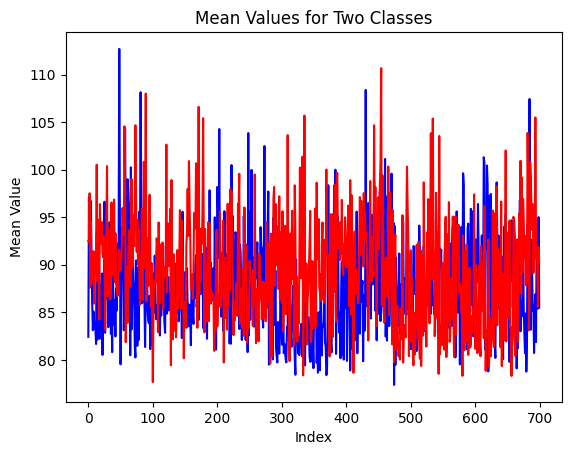

([82.4176025390625,
  97.07027626037598,
  91.31766128540039,
  92.42785835266113,
  96.69599914550781,
  89.97764587402344,
  86.01136779785156,
  83.11203384399414,
  85.08687400817871,
  83.2841854095459,
  83.98781394958496,
  83.30560302734375,
  81.66462135314941,
  93.32649421691895,
  82.11490249633789,
  88.86105346679688,
  94.72624397277832,
  86.09425735473633,
  82.21078300476074,
  87.91135597229004,
  84.9875316619873,
  89.08902931213379,
  80.51606369018555,
  85.9108657836914,
  86.79203796386719,
  96.63142967224121,
  82.84543037414551,
  92.8812141418457,
  86.63630485534668,
  86.41084671020508,
  93.58150100708008,
  83.43319320678711,
  86.86853408813477,
  94.47654342651367,
  89.42510223388672,
  82.73726463317871,
  84.87576675415039,
  80.81009483337402,
  88.93868637084961,
  86.48820495605469,
  83.63488578796387,
  86.25834655761719,
  82.45941352844238,
  87.52499961853027,
  85.16280555725098,
  92.20652198791504,
  88.10784530639648,
  92.9786109924316

In [6]:
# visualize
visualize(extracted_gan, extracted_real)

## **Data Preparation before feeding to the classifier**
- assigning of labels
- flattening of feature vector

In [17]:
# prepare the data
labels, datasets = prepare_data(extracted_gan, extracted_real)

----------------------------Preparing the Data-------------------------------

Labels:  1400
Datasets:  1400


## **Run this cell if you want to store the data in txt**
- it can be useful for storing training data to avoid repetition of process

**Suggested format**
- train_labels.txt
- train_features.txt
   

In [23]:
# Save the data
np.savetxt("/Users/Danniel/Downloads/Datasets/Text File Data/train_labels_animals.txt", labels)
np.savetxt("/Users/Danniel/Downloads/Datasets/Text File Data/train_features_animals.txt", datasets)

**Load the data**

In [ ]:
# Load the data
loaded_labels = np.loadtxt("/Users/Danniel/Downloads/Datasets/Text File Data/train_labels_faces_orig.txt")
loaded_features = np.loadtxt("/Users/Danniel/Downloads/Datasets/Text File Data/train_features_faces_orig.txt")

print("Labels: ", len(loaded_labels))
print("Features: ", len(loaded_features))

## **Model Training**
- Liblinear


***
    - change the parameter if the data are from loaded text file
    - train_model(loaded_labels, loaded_features)

In [10]:
# train the data
model = train_linear_model(labels, datasets, C=1)

----------------------Model Training in Liblinear--------------------------

Cross Validation Accuracy = 84.6429%
84.64285714285714


## **Save the model using ".model" extension**

In [11]:
# save the model
model_file = "/Users/Danniel/Downloads/Model/True Model/animals_diverse.model"
save_model(model_file, model)

## **Load the model***

In [26]:
model_file = load_model("/Users/Danniel/Downloads/Model/True Model/animals_diverse.model")
plat_file = load_model("/Users/Danniel/Downloads/Model/True Platt Scaling/platt_scale_animals.model")

## **Model Testing**
- provide directory (folder) for testing datasets

## *Testing Combined GAN and Real Images*
- use "predict" if model is trained in liblinear
- use "svm_predict" if model is trained in libsvm

In [27]:
from preprocessing import preprocessing
import os
import numpy as np
from train import spatial_frequency_feature_fusion
from prob_estimates import get_prob

# test the model
def get_test_data(directory):
    images = []

    # load the images and store in images list
    for filename in os.listdir(directory):
        image = os.path.join(directory, filename)
        if image is not None:
            images.append(image)

    # preprocessing
    preprocessed_img = []
    for i in images:
        preprocessed_img.append(preprocessing(i))   

    # flatten the feature vector
    fused_features = spatial_frequency_feature_fusion(preprocessed_img)
    labels = np.ones((len(fused_features), 1)) 
    true_label = labels.reshape(labels.shape[0])

    feature_vector = []
    for i in fused_features:
        print(i)
        feature_vector.append(i.flatten())


    return feature_vector


def prepare_test_data(gan, real):
    print("\n\n-------------------PREPARING TEST DATA----------------------------\n")
    #label real  and gan datasets
    gan_label = np.ones((len(gan), 1))
    real_label = np.zeros((len(real), 1))

    # combine the labels and datasets
    dataset_labels = np.vstack((gan_label, real_label))
    datasets = np.vstack((gan, real))

    feature_vector = [i.flatten() for i in datasets]
    true_label = dataset_labels.reshape(dataset_labels.shape[0])

    return feature_vector, true_label


def predict_labels(feature_vector, true_label, model, platt):  
    # predict the result
    print("\n\n-------------------THE MODEL IS PREDICTING----------------------------\n")
    _, _, svm_scores= predict(true_label, feature_vector, model)
    predicted_labels, likelihood = get_prob(svm_scores, platt)


    print("------------------------------------------RESULT-----------------------------------\n")
    result = []
    for i in predicted_labels:
        if i == 1.0:
            result.append("GAN")
        elif i == 0.0:
            result.append("Real")

    
    print(predicted_labels)
    print(likelihood)

    return svm_scores



while True:
    option = input("Does your data came from text file? (y/n)")

    if option.lower() == "y":
        # mode prediction
        scores = predict_labels(datasets, labels, model_file)
        break

    elif option.lower() == "n":           
        #provide directory for testing dataset
        dir_gan = "/Users/Danniel/Downloads/Datasets/Datasets Animals/Test/GAN test"
        dir_real = "/Users/Danniel/Downloads/Datasets/Datasets Animals/Test/Real test"

        # undergo spatial-frequency-feature fusion
        gan = get_test_data(dir_gan)
        real = get_test_data(dir_real)

        # combine the real and gan data
        features, labels = prepare_test_data(gan, real)

        # model prediction
        scores = predict_labels(features, labels, model_file, plat_file)
        break
    
    else:
        print("Invalid Input")



...

Performing image resizing
...

Applying Gaussian Noise Reduction


...

Performing image resizing
...

Applying Gaussian Noise Reduction


...

Performing image resizing
...

Applying Gaussian Noise Reduction


...

Performing image resizing
...

Applying Gaussian Noise Reduction


...

Performing image resizing
...

Applying Gaussian Noise Reduction


...

Performing image resizing
...

Applying Gaussian Noise Reduction


...

Performing image resizing
...

Applying Gaussian Noise Reduction


...

Performing image resizing
...

Applying Gaussian Noise Reduction


...

Performing image resizing
...

Applying Gaussian Noise Reduction


...

Performing image resizing
...

Applying Gaussian Noise Reduction


...

Performing image resizing
...

Applying Gaussian Noise Reduction


...

Performing image resizing
...

Applying Gaussian Noise Reduction


...

Performing image resizing
...

Applying Gaussian Noise Reduction


...

Performing image resizing
...

Applying Gaussian Noise Re

## *Testing One Class of Image only*
- use "predict" if model is trained in liblinear

In [ ]:
from preprocessing import preprocessing
import os
import numpy as np
from train import spatial_frequency_feature_fusion

# test the model
def get_test_data(directory):
    images = []

    # load the images and store in images list
    for filename in os.listdir(directory):
        image = os.path.join(directory, filename)
        if image is not None:
            images.append(image)

    # preprocessing
    preprocessed_img = []
    for i in images:
        preprocessed_img.append(preprocessing(i))   

    # flatten the feature vector
    fused_features = spatial_frequency_feature_fusion(preprocessed_img)
    labels = np.ones((len(fused_features), 1)) 
    true_label = labels.reshape(labels.shape[0])

    feature_vector = []
    for i in fused_features:
        print(i)
        feature_vector.append(i.flatten())


    return feature_vector


def prepare_test_data(gan):
    print("\n\n-------------------PREPARING TEST DATA----------------------------\n")
    #label real  and gan datasets
    #real_label = np.ones((len(real), 1))
    gan_label = np.zeros((len(gan), 1))

    # combine the labels and datasets
    #dataset_labels = np.vstack((real_label, gan_label))
    #datasets = np.vstack((real, gan))

    feature_vector = [i.flatten() for i in gan]
    true_label = gan_label.reshape(gan_label.shape[0])

    return feature_vector, true_label


def predict(feature_vector, true_label, model):  
    # predict the result
    print("\n\n-------------------THE MODEL IS PREDICTING----------------------------\n")
    predicted_labels, _, likelihood = svm_predict(true_label, feature_vector, model, '-b 1')


    print("------------------------------------------RESULT-----------------------------------\n")
    result = []
    for i in predicted_labels:
        if i == 1.0:
            result.append("Real")
        elif i == 0.0:
            result.append("GAN")

    
    print(predicted_labels)
    print(result)



while True:
    option = input("Does your data came from text file? (y/n)")

    if option.lower() == "y":
        # mode prediction
        predict(loaded_features, loaded_labels, model_file)
        break

    elif option.lower() == "n":           
        #provide directory for testing dataset
        #dir_real = "/Users/User/Desktop/real test/real test objects"
        dir_gan = "/Users/User/Desktop/gan test/gan test objects"

        # undergo spatial-frequency-feature fusion
        #real = get_test_data(dir_real)
        gan = get_test_data(dir_gan)

        # combine the real and gan data
        features, labels = prepare_test_data(gan)

        # model prediction
        predict(features, labels, model_file)
        break
    
    else:
        print("Invalid Input")

## **Store the test data in txt file**

In [ ]:
# Save the data
np.savetxt("/Users/User/Desktop/txtfiles/test_labels.txt", labels)
np.savetxt("/Users/User/Desktop/txtfiles/test_features.txt", features)

## **Platt Scaling**
- run this to provide the platt scaling of the model
- variable *scores* will be obtained when testing is run (this code should be run after getting all the svm_scores of the training data)
- change the parameter of train accordingly

In [25]:
from liblinear.liblinearutil import train

validate = train(labels, scores, '-s 0 -c 1 -B 1 -v 5')
platt_scale = train(labels, scores, '-s 0 -c 1 -B 1')

save_model('/Users/Danniel/Downloads/Model/True Platt Scaling/platt_scale_animals.model', platt_scale)

Cross Validation Accuracy = 100%
